In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from glob import glob
import random
import os

#CNN
from keras.models import Sequential
from keras.layers import Convolution2D, Flatten, Dense, Input, MaxPooling2D, Dropout
#Metrics
from sklearn.metrics import classification_report,confusion_matrix

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [ ]:
paths=["/kaggle/input/waste-classification-data/DATASET/TRAIN","/kaggle/input/waste-classification-data/DATASET/TEST"]

In [ ]:
labels=[]
for folder in os.listdir(paths[0]):
    labels.append(folder)

dicc_labels = {i:label for i, label in enumerate(os.listdir(paths[0]))}
dicc_labels

{0: 'R', 1: 'O'}

<h2>Resize image (?,?)->(80,80) <h2>

In [ ]:
import numpy as np
n=[]
s=80
_images=[]
_labels=[]
for j in range(0,2):
  for i,folder in enumerate(labels):
      try:
          for image in os.listdir(paths[j] +'/'+folder):
              img = os.path.join(paths[j]+'/'+folder+'/'+image)
              img = cv2.imread(img)
              img = cv2.resize(img,(s,s))
              img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
              #img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  #if you want to use scale gray
              _images.append(img)
              _labels.append(i)
      except:
          print("siuu")
  n.append(len(_images))

_images = np.asarray(_images)
_labels = np.asarray(_labels).astype('int64')
print("images-> ",_images.shape)
print(" datas per label-> ",np.bincount(_labels))

images->  (25077, 80, 80, 3)
 datas per label->  [11111 13966]


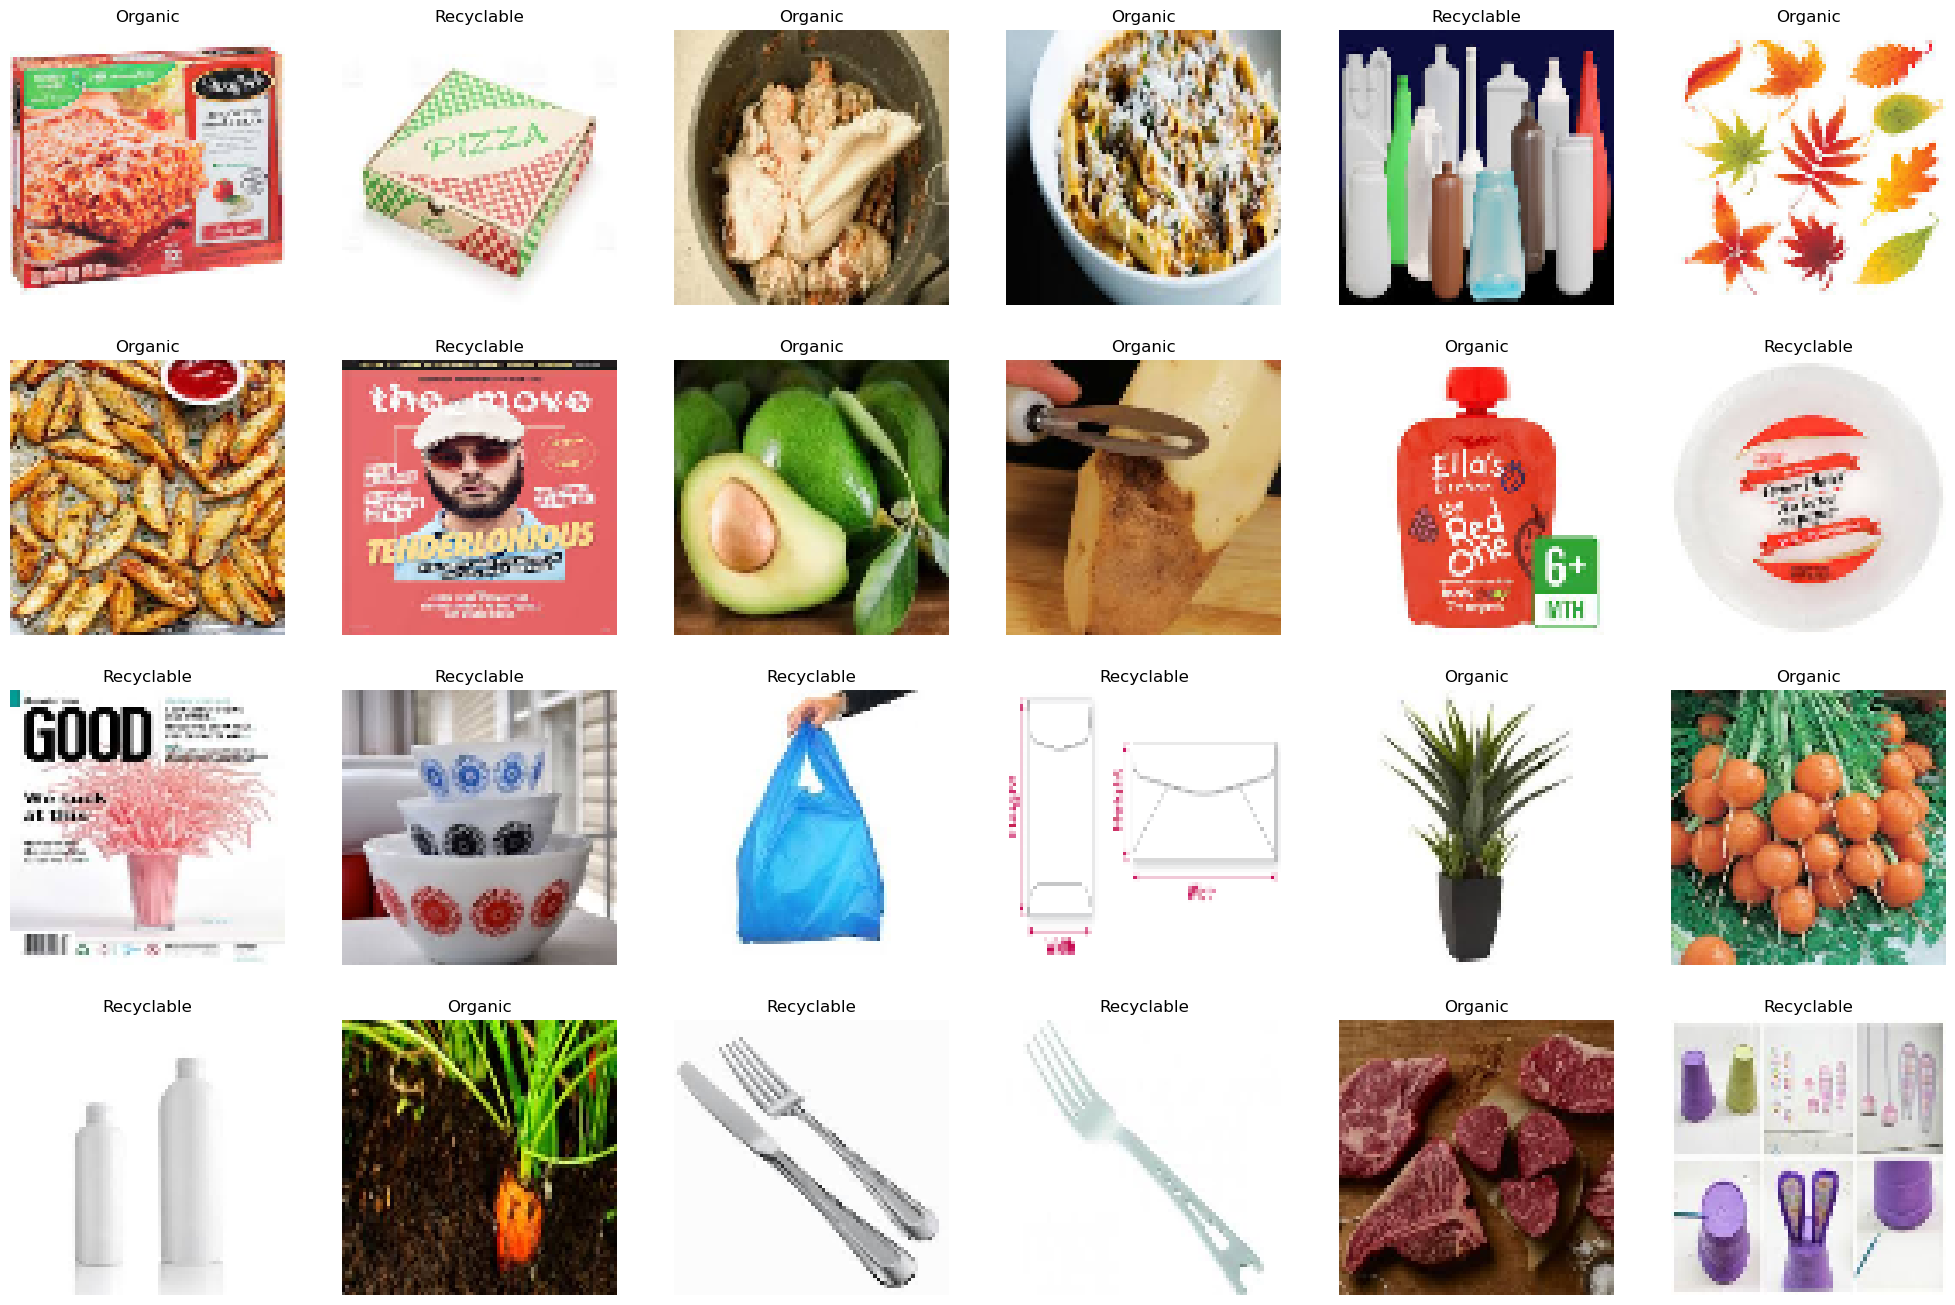

In [ ]:
plt.figure(figsize=(25,25))
for i in range(0,24):
    pos= random.randint(0,int(11111+13966))
    plt.subplot(6,6,i+1)
    plt.imshow(_images[pos])
    plt.axis('off')
    plt.title('Organic' if _labels[pos]==1 else 'Recyclable')

<h2> Scale the images makes CNN work faster<h2>

In [ ]:
from sklearn.preprocessing import StandardScaler
scal = StandardScaler()
_images =_images.reshape((len(_images),-1))
scal.fit(_images)
_images_scal = scal.transform(_images) #Genera el nuevo dataset

In [ ]:
n #n[:22564]-> train, n[22565:25077]->test

[22564, 25077]

In [ ]:
X_train=_images_scal[0:n[0]]  #[0:22564]
y_train=_labels[0:n[0]] #[0:22564]

X_test=_images_scal[n[0]:n[1]] #[22564:25077]
y_test=_labels[n[0]:n[1]]       #[22564:25077]


X_train =X_train.reshape(len(X_train),s,s,3) # s->size. 80
X_test = X_test.reshape(len(X_test),s,s,3)

print("imagenes train-> ",X_train.shape,"labels train-> ",y_train.shape)
print("labels train por categoría-> ",np.bincount(y_train))
print("imagenes test-> ",X_test.shape,"labels train-> ",y_test.shape)
print("label test por categoría-> ",np.bincount(y_test))


imagenes train->  (22564, 80, 80, 3) labels train->  (22564,)
labels train por categoría->  [ 9999 12565]
imagenes test->  (2513, 80, 80, 3) labels train->  (2513,)
label test por categoría->  [1112 1401]


In [ ]:
y_train[:5]

array([0, 0, 0, 0, 0])

<h2>Model<h2>

In [ ]:
#Number of neurons based on kolmogorov
modelo = Sequential()
modelo.add(Input(shape=(s,s,3)))
modelo.add(Convolution2D(s, kernel_size=3, activation="relu", padding="valid"))
modelo.add(MaxPooling2D(pool_size=(2,2)))
modelo.add(Dropout(0.5))
modelo.add(Convolution2D(s*2, kernel_size=3, activation="relu", padding="valid"))
modelo.add(MaxPooling2D(pool_size=(2,2)))
modelo.add(Dropout(0.5))
modelo.add(Convolution2D(s/2, kernel_size=3, activation="relu", padding="valid"))
modelo.add(MaxPooling2D(pool_size=(2,2)))
modelo.add(Dropout(0.5))
modelo.add(Flatten())
modelo.add(Dense(1, activation="sigmoid"))

modelo.compile(optimizer="adam", loss="binary_crossentropy",
               metrics=["accuracy","Precision"]
)

modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 80)        2240      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 39, 39, 80)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 39, 39, 80)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 160)       115360    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 160)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 18, 18, 160)       0

Epoch 1/30


2023-12-09 05:06:30.287119: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


706/706 [==============================] - 19s 14ms/step - loss: 0.7094 - accuracy: 0.7410 - precision: 0.7681
Epoch 2/30
706/706 [==============================] - 10s 14ms/step - loss: 0.7982 - accuracy: 0.7407 - precision: 0.7693
Epoch 3/30
706/706 [==============================] - 10s 13ms/step - loss: 1.3861 - accuracy: 0.7329 - precision: 0.7610
Epoch 4/30
706/706 [==============================] - 9s 13ms/step - loss: 3.1069 - accuracy: 0.7328 - precision: 0.7563
Epoch 5/30
706/706 [==============================] - 9s 13ms/step - loss: 7.8493 - accuracy: 0.7356 - precision: 0.7564
Epoch 6/30
706/706 [==============================] - 9s 13ms/step - loss: 9.1742 - accuracy: 0.7476 - precision: 0.7662
Epoch 7/30
706/706 [==============================] - 9s 13ms/step - loss: 10.1529 - accuracy: 0.7456 - precision: 0.7659
Epoch 8/30
706/706 [==============================] - 9s 13ms/step - loss: 16.7451 - accuracy: 0.7460 - precision: 0.7669
Epoch 9/30
706/706 [==================

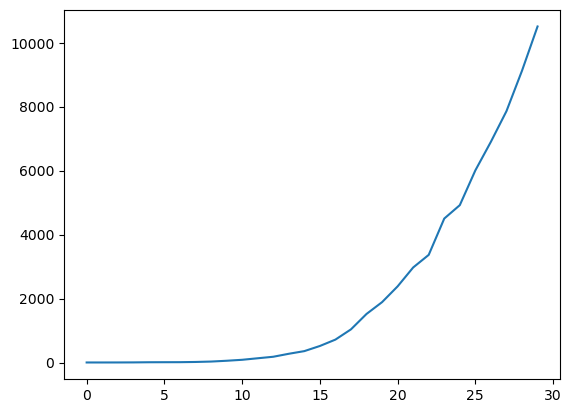

In [ ]:
historial=modelo.fit(X_train, y_train, validation_batch_size=(X_test,y_test),epochs=30)
plt.plot(historial.history["loss"])
pred = modelo.predict(X_test)

pred_labels = (pred >= 0.5).astype(int)


<h3>Classification report<h3>

In [ ]:

pred = modelo.predict(X_test)
pred=np.where(pred >= 0.5, 1, 0)
print(classification_report(
    y_test,
    pred
))

79/79 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.94      0.40      0.56      1112
           1       0.67      0.98      0.80      1401

    accuracy                           0.72      2513
   macro avg       0.81      0.69      0.68      2513
weighted avg       0.79      0.72      0.69      2513



<h3>Confusion matrix <h3>

In [ ]:
cm=confusion_matrix(y_test,pred)
cm

array([[ 445,  667],
       [  29, 1372]])

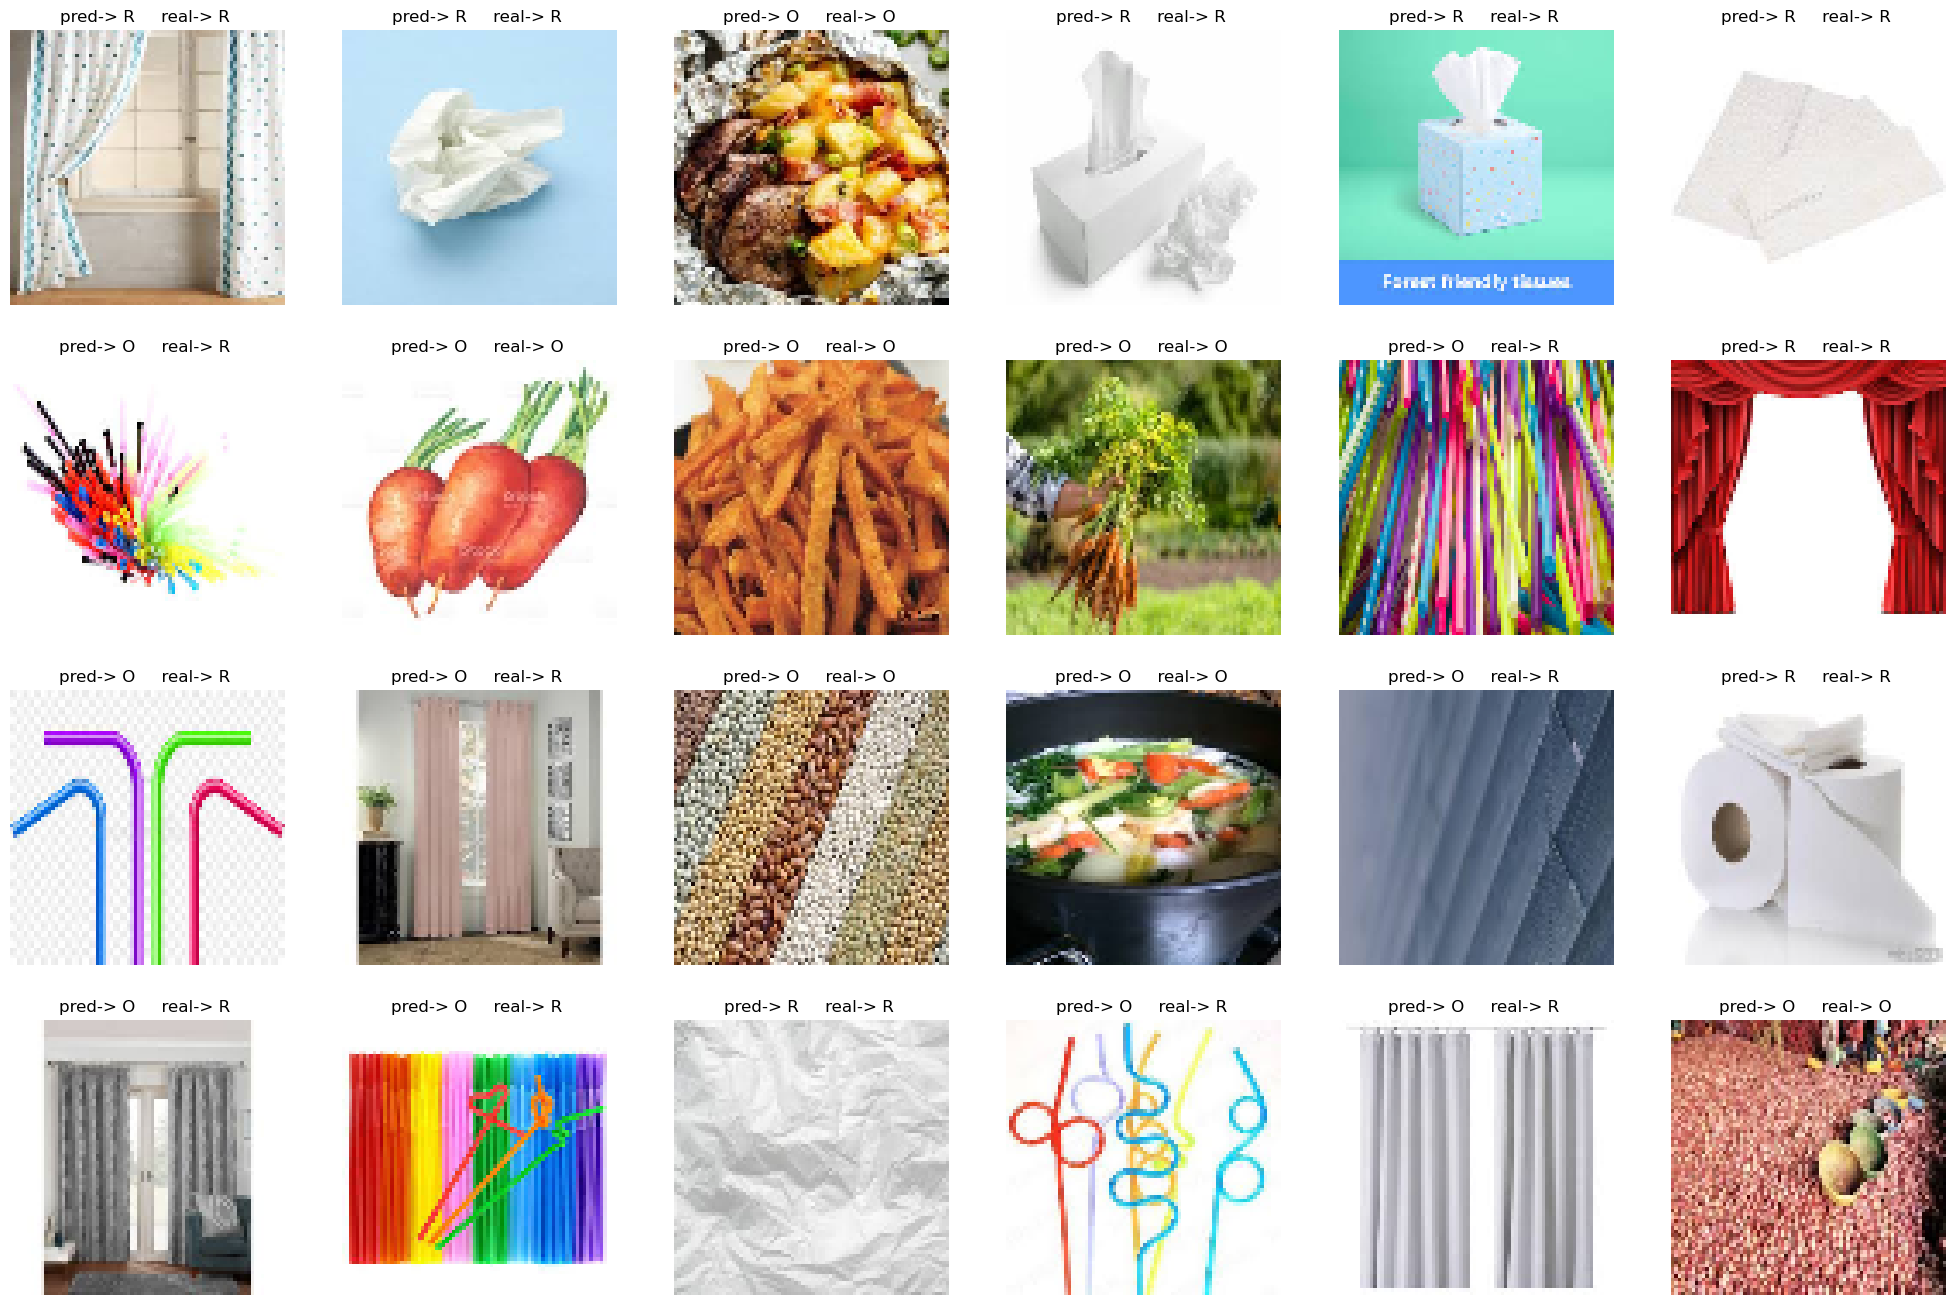

In [ ]:

_images =_images.reshape(len(_images),s,s,3)
plt.figure(figsize=(25,25))
for i in range(0,24):
    pos= random.randint(0,int(n[1]-n[0]))
    plt.subplot(6,6,i+1)
    plt.imshow(_images[n[0]+pos])
    plt.axis('off')
    plt.title("pred-> %s     real-> %s "%(dicc_labels[pred[pos][0]],dicc_labels[y_test[pos]]))

In [ ]:
modelo.save('modelo_waste.h5')

In [ ]:
import tensorflow as tf
loaded_model = tf.keras.models.load_model('/kaggle/working/modelo_waste.h5')
loaded_model

In [ ]:
def preprocess_images(path):
    img = image.load_img(path, target_size=(224, 224))

    img_array = image.img_to_array(img)

    img_array = np.expand_dims(img_array, axis=0)

    img_preprocessed = img_array / 255.0

    return img_preprocessed